<a href="https://colab.research.google.com/github/vggls/msc_thesis_medical_xai/blob/main/experiments/crc_resnet34/ResNet34_Training_%26_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import shutil
import random
import pickle
from collections import OrderedDict

In [ ]:
import torch
from torchvision  import datasets, transforms
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
# custom written code
from crc import create_datasets, summaries
from training_loop import Train
from train_model import fit
from imbalanced import class_weights
from resnet import ResNet
from testing_report import Test_Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Load .zip files from Google Drive and unzip them**

In [ ]:
!unzip "./drive/My Drive/Datasets/CRC/NCT-CRC-HE-100K.zip" # training and validation images, 100K

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYVEKTQH.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYPWAIM.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYQVPLI.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-PYYRLNYI.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QADCETNL.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QADWKAWV.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAELGSKC.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAEWQKCK.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAFCMDLW.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAGYSSNM.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAHPWERH.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAIQQTEC.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAISCSQV.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAKWPLCE.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QALEPWFA.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QALGHAQL.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAMFQMMD.tif  
  inflating: NCT-CRC-HE-100K/TUM/TUM-QAMICSMH.tif  
  inflati

In [ ]:
!unzip "./drive/My Drive/Datasets/CRC/CRC-VAL-HE-7K.zip" # test set 7K

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ACMSDEFF.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ACQQYLLS.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ADCHTGEE.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AFELDRPS.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AFFMDFQV.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AFQQTGKI.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AGKPYMDE.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AHDNMNIT.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AHKLPKMS.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AHQCDGMY.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AIIGEWYP.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ALLMHHRT.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ALQTIPLF.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-APHIEAQK.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-AQGAYQML.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ARHEISPN.tif  
  inflating: CRC-VAL-HE-7K/DEB/DEB-TCGA-ARIHITHS.tif  
  inflatin

# **3. A first look at the data: Class distribution**

In [ ]:
# use this to print class distribution of directlty downloaded datasets
classes = {'ADI': 'Adipose (ADI)',
          'BACK': 'Background (BACK)',
          'DEB': 'Debris (DEB)',
          'LYM': 'Lymphocytes (LYM)',
          'MUC': 'Mucus (MUC)',
          'MUS': 'Smooth muscle (MUS)',
          'NORM': 'Normal colon mucosa (NORM)',
          'STR': 'Cancer-associated stroma (STR)',
          'TUM': 'Colorectal adenocarcinoma epithelium (TUM)'}

In [ ]:
for dataset in ['NCT-CRC-HE-100K', 'CRC-VAL-HE-7K']:
    points = []
    names = []
    total = 0
    for clas in classes:
        names.append(classes[clas])
        class_path = './' + dataset + '/' + clas
        points.append(len(os.listdir(class_path)))
        total += len(os.listdir(class_path))

    fig = go.Figure()
    for i, clas in enumerate(classes):
        percent = round(points[i] / total * 100, 2)
        text = f"{points[i]} ({percent}%)"
        fig.add_trace(go.Bar(x=[clas], y=[points[i]], text=[text], textposition='outside', showlegend=False, marker=dict(color="steelblue")))

    #fig = go.Figure([go.Bar(x=names, y=points, text=points, textposition='outside')])
    fig.update_layout(width=1200, height=600, title='{}: Class distribution'.format(dataset), title_x=0.5)
    fig.show()

# **4. Train, Validation and Test datasets**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),      #data augmentation
    transforms.RandomVerticalFlip(),        #data augmentation
    transforms.RandomRotation(degrees=30),  #data augmentation
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
shutil.rmtree('./training_dataset')
shutil.rmtree('./validation_dataset')

In [ ]:
train_dataset, validation_dataset, test_dataset = create_datasets(train_transforms, test_transforms)

In [ ]:
# now i could run this cell to save some memory space
#shutil.rmtree('./NCT-CRC-HE-100K')

In [ ]:
print(train_dataset.class_to_idx)
print(validation_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}
{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}
{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


In [ ]:
summaries()

# **5. Dataset Visualization**

<Figure size 432x288 with 0 Axes>

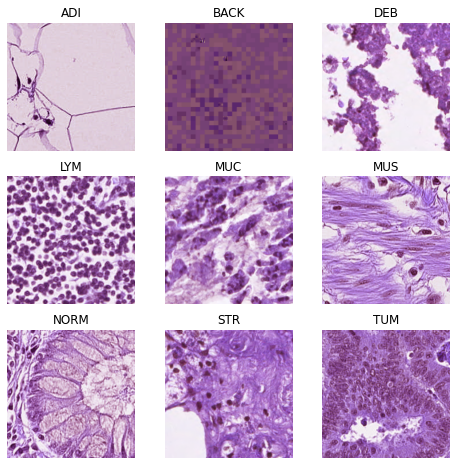

In [ ]:
dataset_path = '/content/NCT-CRC-HE-100K'

indices = []
for i in range(3):
    for j in range(3):
        index_pair = (i, j)
        indices.append(index_pair)

plt.figure()

fig, ax = plt.subplots(3, 3, figsize=(8, 8))

for index, clas in zip(indices,classes):
    class_path = os.path.join(dataset_path, clas)
    class_image = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, class_image)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    ax[index].imshow(img)
    ax[index].set_title(clas)
    ax[index].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

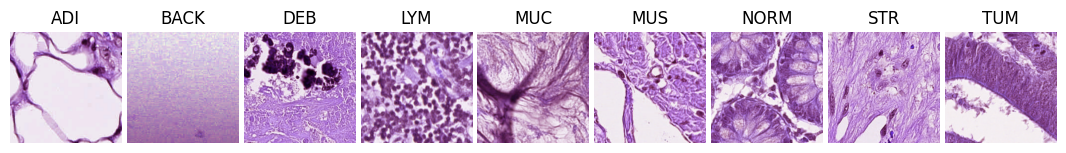

In [ ]:
dataset_path = '/content/NCT-CRC-HE-100K'

plt.figure()

fig, ax = plt.subplots(1, 9, figsize=(13.5, 1.5))
indices = [0,1,2,3,4,5,6,7,8]

for index, clas in zip(indices,classes):
    class_path = os.path.join(dataset_path, clas)
    class_image = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, class_image)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    ax[index].imshow(img)
    ax[index].set_title(clas)
    ax[index].axis('off')

plt.subplots_adjust(wspace=0.05)
plt.show()

# **6. ResNet34**

In [ ]:
weights = class_weights('./training_dataset/', train_dataset)

ADI class - instances 8325 - assigned weight 0.00012012012012012012
BACK class - instances 8452 - assigned weight 0.0001183151916706105
DEB class - instances 9209 - assigned weight 0.0001085894233901618
LYM class - instances 9245 - assigned weight 0.00010816657652785289
MUC class - instances 7116 - assigned weight 0.0001405283867341203
MUS class - instances 10828 - assigned weight 9.235315847801995e-05
NORM class - instances 7010 - assigned weight 0.0001426533523537803
STR class - instances 8356 - assigned weight 0.00011967448539971278
TUM class - instances 11453 - assigned weight 8.731336767659129e-05


In [ ]:
resnet34 = ResNet(type_ = '34',
                  no_of_classes = 9,
                  trainable_layers = [6, 7])

>**training**

In [ ]:
loss_fct = torch.nn.CrossEntropyLoss(weights.cuda())
optimizer = optim.Adam(resnet34.model.parameters(), lr=0.0001)

training_dict, validation_dict = fit(train_dataset=train_dataset,
                                     validation_dataset=validation_dataset,
                                     batch_size=256,
                                     model=resnet34,
                                     loss_fct=loss_fct,
                                     optimizer=optimizer,
                                     scheduler=None,
                                     epochs=100,
                                     patience=7,
                                     no_of_classes=9,
                                     labels_of_normal_classes=None)

Device: cuda:0
Starting training..
-----------------------------------
Epoch 1/100
->Training phase
  Loss=0.1303
  Accuracy=0.96 - Recall per class=[0.99, 0.99, 0.96, 0.99, 0.96, 0.93, 0.95, 0.92, 0.95]
->Validation phase
  Loss=0.0630
  Accuracy=0.98 - Recall per class=[1.0, 1.0, 0.94, 1.0, 0.98, 0.97, 0.98, 0.98, 0.98]
->New model saved!
-----------------------------------
Epoch 2/100
->Training phase
  Loss=0.0463
  Accuracy=0.99 - Recall per class=[1.0, 1.0, 0.98, 1.0, 0.99, 0.98, 0.98, 0.97, 0.98]
->Validation phase
  Loss=0.0281
  Accuracy=0.99 - Recall per class=[1.0, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
->New model saved!
-----------------------------------
Epoch 3/100
->Training phase
  Loss=0.0344
  Accuracy=0.99 - Recall per class=[1.0, 1.0, 0.99, 1.0, 0.99, 0.98, 0.99, 0.98, 0.98]
->Validation phase
  Loss=0.0258
  Accuracy=0.99 - Recall per class=[1.0, 1.0, 0.99, 1.0, 0.99, 0.98, 0.98, 0.99, 0.99]
-----------------------------------
Epoch 4/100
->Training phase


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete !


In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/CRC/Models/'
with open(drive_path + 'crc_resnet34_training_dict.pickle', 'wb') as f:
  pickle.dump(training_dict, f)
with open(drive_path + 'crc_resnet34_validation_dict.pickle', 'wb') as f:
  pickle.dump(validation_dict, f)

>**loss history plot**

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(training_dict['loss'])+1 )), y=training_dict['loss'], name='Training'))
fig.add_trace(go.Scatter(x=list(range(1, len(validation_dict['loss'])+1 )), y=validation_dict['loss'], name='Validation'))
fig.update_layout(title='ResNet34 Loss history (Optimal model at epoch 22)',
                  title_x=0.5,
                   xaxis_title='Epochs',
                   yaxis_title='Loss',
                  height=400, width=800,)
fig.show()

>**testing**

In [ ]:
#test
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
classes = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR','TUM']

drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/CRC/Models/'
resnet34 = torch.load(drive_path + 'crc_resnet34.pt')

test_report = Test_Report(test_loader, resnet34, classes)

Device: cuda:0


In [ ]:
print('\033[1m' + 'Model: crc_resnet34.pt' + '\033[0m \n')
test_report.classification_report()
bal_acc=test_report.balanced_accuracy()
print(f'Balanced Accuracy Score: {round(bal_acc, 2)}')

Model: crc_resnet34.pt 

              precision    recall  f1-score   support

         ADI       1.00      0.84      0.91      1338
        BACK       0.97      1.00      0.98       847
         DEB       0.95      0.79      0.87       339
         LYM       0.98      0.98      0.98       634
         MUC       0.98      0.99      0.98      1035
         MUS       0.56      0.85      0.68       592
        NORM       0.96      0.98      0.97       741
         STR       0.87      0.60      0.71       421
         TUM       0.95      0.98      0.96      1233

    accuracy                           0.91      7180
   macro avg       0.91      0.89      0.89      7180
weighted avg       0.93      0.91      0.92      7180

Balanced Accuracy Score: 0.89


In [ ]:
print('\033[1m' + 'Model: crc_resnet34.pt' + '\033[0m')
scores = test_report.roc_curve_and_scores(plot=True)
print(f'Mean AUC score: {round(sum(scores)/len(scores),3)}')
_ = test_report.pr_curve_and_scores(plot=True)

Model: crc_resnet34.pt


Mean AUC score: 0.993
